In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import numpy as np
import matplotlib.pyplot as plt


for folder in ['anchor', 'positive', 'negative']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# ----------------------------
# Custom Distance Layer
# ----------------------------
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

# ----------------------------
# Feature Extractor
# ----------------------------
def make_embedding():
    inp = Input(shape=(100, 100, 3))

    x = Conv2D(64, (10, 10), activation='relu')(inp)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=x)

# ----------------------------
# Siamese Network
# ----------------------------
embedding = make_embedding()

input_image = Input(shape=(100, 100, 3))
val_image   = Input(shape=(100, 100, 3))

siamese_layer = L1Dist()

distances = siamese_layer([
    embedding(input_image),
    embedding(val_image)
])

classifier = Dense(1, activation='sigmoid')(distances)

siamese_model = Model(
    inputs=[input_image, val_image],
    outputs=classifier
)

siamese_model.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

siamese_model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 4096)      │ 210,140,0… │ input_layer_22[0… │
│ (Functional)        │                   │            │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_6 (L1Dist)  │ (None, 4096)      │          0 │ functional_7[0][… │
│                     │                   │            │ functional_7[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 210,144,193 (801.64 MB)

 Trainable params: 210,144,193 (801.64 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

siamese_model.save('siamese_model.h5')
print("Saved siamese_model.h5 successfully!")

Saved siamese_model.h5 successfully!


In [11]:
def show_result(img1_path, img2_path):
    img1 = cv2.imread(img1_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.imread(img2_path)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Simple prediction logic
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img1); plt.title("Base Image")
    plt.subplot(1,2,2); plt.imshow(img2); plt.title("Test Image")
    plt.show()




In [12]:
siamese_model.save('siamese_model.h5')


In [14]:

import glob

# This function grabs all common image types
def get_files(folder):
    files = glob.glob(f'{folder}/*.jpg') + glob.glob(f'{folder}/*.jpeg') + glob.glob(f'{folder}/*.png')
    return files

# Convert the python list of files to a TensorFlow dataset
anchor_files = get_files('anchor')
positive_files = get_files('positive')
negative_files = get_files('negative')

# Check if files were actually found
print(f"Found {len(anchor_files)} anchor images.")
print(f"Found {len(positive_files)} positive images.")
print(f"Found {len(negative_files)} negative images.")

if len(anchor_files) == 0:
    print("❌ ERROR: No images found in 'anchor'. Please check file extensions!")
else:
    anchor = tf.data.Dataset.from_tensor_slices(anchor_files).take(10)
    positive = tf.data.Dataset.from_tensor_slices(positive_files).take(10)
    negative = tf.data.Dataset.from_tensor_slices(negative_files).take(10)

    # Continue with dataset creation...
    positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
    negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
    data = positives.concatenate(negatives)

    # Preprocessing wrapper
    def preprocess_path(input_path, validation_path, label):
        return (preprocess(input_path), preprocess(validation_path)), label

    train_data = data.map(preprocess_path).cache().shuffle(buffer_size=1024).batch(16).prefetch(8)
    print("✅ Dataset created successfully!")


Found 1 anchor images.
Found 18 positive images.
Found 15 negative images.
✅ Dataset created successfully!


In [15]:

siamese_model.fit(train_data, epochs=10)

siamese_model.save('siamese_model.h5')
print("Training complete. siamese_model.h5 updated with your face data!")

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 0.6900
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.5710
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.0278
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.0014
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.0019
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.0039
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 3.0447e-04
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 4.7589e-05
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 1.3170e-05
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 5.1213e-06


Training complete. siamese_model.h5 updated with your face data!


Testing with actual files found:
Anchor: anchor/WhatsApp Image 2026-02-02 at 18.13.50.jpeg
Positive: positive/WhatsApp Image 2026-02-02 at 18.13.52.jpeg

--- Visualizing Result ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


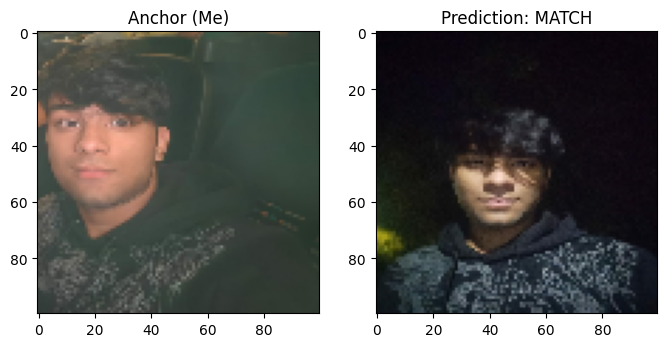

In [17]:
import os

anchor_files = os.listdir('anchor')
positive_files = os.listdir('positive')
negative_files = os.listdir('negative')


if len(anchor_files) == 0 or len(positive_files) == 0 or len(negative_files) == 0:
    print("❌ ERROR: One of your folders is empty! Please upload images.")
else:

    real_anchor = os.path.join('anchor', anchor_files[0])
    real_positive = os.path.join('positive', positive_files[0])
    real_negative = os.path.join('negative', negative_files[0])

    print(f"Testing with actual files found:\nAnchor: {real_anchor}\nPositive: {real_positive}")


    print("\n--- Visualizing Result ---")
    verify(siamese_model, real_anchor, real_positive)